# Imports

In [ ]:
from keras.models import load_model
import os
import utils
import random
import numpy as np
import models
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import imageio
from augmentation import augment_from_path
from imageproc import Image
from keras.callbacks import *
plt.style.use('seaborn')

# Create model

In [ ]:
model = models.get_model('vgg16', 'unet', input_shape = (256, 256, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [ ]:
dot = plot_model(model)
dot.write('model_graph.png', format = 'png')
fig, ax = plt.subplots(1, 1, figsize = (20, 400))
ax.imshow(imageio.imread('model_graph.png'))
ax.set_axis_off()
plt.show()

# Create Training Set

### Augmentate images

In [ ]:
X_path, Y_path = './training_set/images', './training_set/masks'

aug_param = {'affine_rotate': 45,
              'affine_scale': 20,
              'affine_shear': 15,
              'affine_flip_vertical': True,
              'affine_flip_horizontal': True,
              'affine_probability': 100,
              'non_affine_saturation': None,
              'non_affine_brightness': None,
              'non_affine_contrast': None,
              'non_affine_shrpen': None,
              'non_affine_grayscale': None,
              'non_affine_emboss': None,
              'non_affine_probability': 0,
              'noise_blur': 2,
              'noise_noise': 10,
              'noise_dropout': 10,
              'noise_salt_and_pepper': 10,
              'noise_frequency': False,
              'noise_probability': 100
            }
sequence_type = 'one_to_one'

augment_from_path(X_path, Y_path, aug_param, sequence_type)


0it [00:00, ?it/s]
1it [00:00,  9.26it/s]
3it [00:00, 10.83it/s]
5it [00:00, 11.24it/s]
6it [00:00, 10.93it/s]
8it [00:00, 11.20it/s]
10it [00:00, 11.29it/s]
12it [00:01, 11.24it/s]
14it [00:01, 11.23it/s]
16it [00:01, 11.21it/s]
18it [00:01, 11.24it/s]
20it [00:01, 11.04it/s]
22it [00:02, 11.00it/s]
24it [00:02, 11.05it/s]
26it [00:02, 11.10it/s]
28it [00:02, 11.10it/s]
30it [00:02, 11.04it/s]
32it [00:02, 10.91it/s]
34it [00:03, 10.95it/s]
36it [00:03, 10.99it/s]
38it [00:03, 11.00it/s]
40it [00:03, 10.93it/s]
42it [00:03, 10.95it/s]
44it [00:04, 10.98it/s]
46it [00:04, 11.00it/s]
48it [00:04, 11.00it/s]
50it [00:04, 11.01it/s]
52it [00:04, 11.02it/s]
54it [00:04, 10.90it/s]
870it [01:23, 10.40it/s]


### Read and vizualize augmentation images

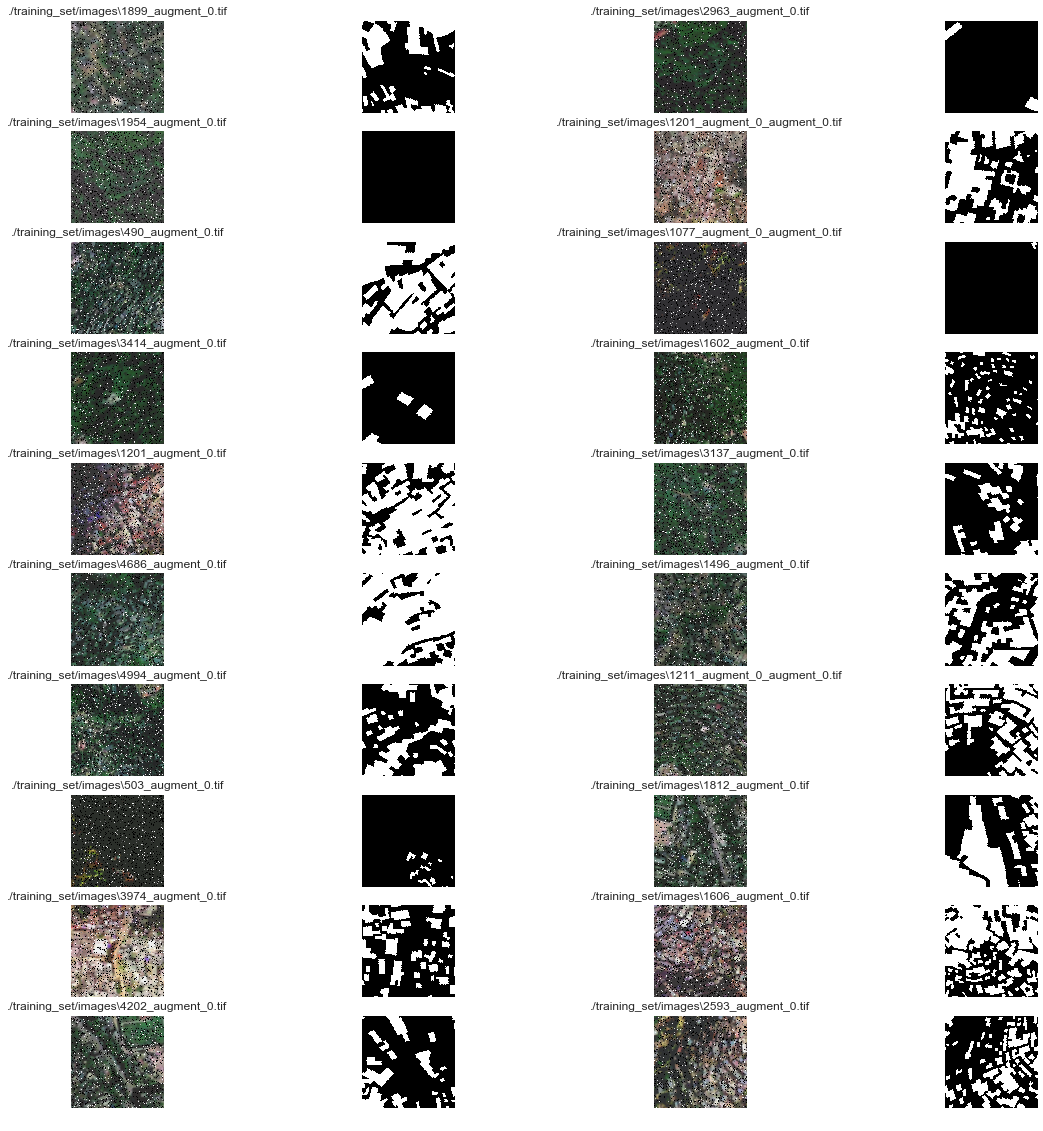

In [ ]:
file_names = os.listdir(X_path)
im_pathes = [os.path.join(X_path, i) for i in file_names if 'augment' in i]
ms_pathes = [os.path.join(Y_path, i) for i in file_names if 'augment' in i]
rnd_indexes = [np.random.choice(list(range(len(im_pathes))), replace = False) for _ in range(20)]
images = np.array([Image(path, is_mask = False).get_array() for count, path in enumerate(im_pathes) if count in rnd_indexes])
masks = np.array([Image(path, is_mask = True).get_array() for count, path in enumerate(ms_pathes) if count in rnd_indexes])

fig, ax = plt.subplots(10, 4, figsize = (20, 20))
axes = [ax[i][j] for i in range(10) for j in range(4)]
for count, im in enumerate(images):
    axes[count*2].imshow(im)
    axes[count*2].set_axis_off()
    axes[count*2].set_title(pathes[rnd_indexes[count]])
    
    axes[count*2+1].imshow(masks[count], 'binary_r')
    axes[count*2+1].set_axis_off()
plt.show()

## Create training set array

In [ ]:
X, Y = utils.get_training_set(X_path, Y_path)

100%|███████████████████████████████████████████████████| 1644/1644 [00:04<00:00, 365.01it/s]


# Create mask coverage chart

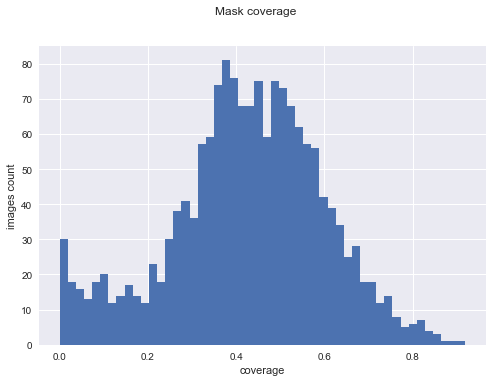

In [ ]:
def get_mask_coverage(Y):
    if Y.ndim==2:
        width, height = Y.shape
        bands = 1
    elif Y.ndim == 3:
        if min(Y.shape) == Y.shape[0]:
            bands, width, height = Y.shape
        elif min(Y.shape) == Y.shape[-1]:
            width, height, bands = Y.shape
    all_pixels = width*height
    if bands == 1:
        target_class_pixels = [len((Y[Y==1]).flatten())]
    else:
        if min(Y.shape) == Y.shape[0]:
            target_class_pixels = [len((Y[n][Y[n]==1]).flatten()) for n in range(bands)]
        else:
            target_class_pixels = [len((Y[:, :, n][Y[:, :, n]==1]).flatten()) for n in range(bands)]
    
    if bands == 1:
        return [(tc/all_pixels) for tc in target_class_pixels][0]
    else:
        return [(tc/all_pixels) for tc in target_class_pixels]


plt.hist([get_mask_coverage(y) for y in Y], bins = 50)
plt.suptitle('Mask coverage')
plt.xlabel('coverage')
plt.ylabel('images count')
plt.show()

# Training model

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(X, Y, validation_split = 0.1, epochs = 100, batch_size = 16, callbacks = [checkpoint])